In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from torch import nn



In [18]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar100 = datasets.CIFAR100(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar_10_train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
cifar_10_val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

cifar_val_x = torch.empty((3, 32, 32, len(cifar10_val)), device=device)
cifar_val_y = torch.empty(len(cifar10_val), dtype=torch.long, device=device)

for epoch, (img, label) in enumerate(cifar10_val):
    cifar_val_x[:, :, :, epoch] = img
    cifar_val_y[epoch] = label

cifar_val_x = cifar_val_x.view(3, -1)


# CIFAR-100
cifar100_train_imgs = torch.stack([img for img, _ in datasets.CIFAR100(data_path, train=True, download=True)], dim=3)
cifar100_mean = cifar100_train_imgs.view(3, -1).mean(dim=1)
cifar100_std = cifar100_train_imgs.view(3, -1).std(dim=1)

cifar100_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

cifar100_train = datasets.CIFAR100(data_path, train=True, download=True, transform=cifar100_transform)
cifar100_train_loader = DataLoader(cifar100_train, batch_size=64, shuffle=True)

cifar100_val = datasets.CIFAR100(data_path, train=False, download=True, transform=cifar100_transform)
cifar100_val_loader = DataLoader(cifar100_val, batch_size=64, shuffle=False)

In [50]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from numbers import Number
from math import floor
import time

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        
        for key, value in results1.items():
            if isinstance(value, Number): print(f"{key} : {100*(value - results2[key]) / value:2f} %") 
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_val=None, Y_pred=None):
        if Y_val is None:
            Y_val = self.last_val
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_val, torch.Tensor):
            Y_val = Y_val.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision': precision_score(Y_val, Y_pred, average='weighted'),
            'recall': recall_score(Y_val, Y_pred, average='weighted'),
            'f1': f1_score(Y_val, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_val, Y_pred),
            'classification_report': classification_report(Y_val, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
    def plot_training(self, title: str):
        loss_hist = self.train_loss_hist.cpu().detach().numpy()
        accuracy_hist = self.train_accuracy_hist.cpu().detach().numpy()
        validation_accuracy_hist = self.validation_accuracy_hist.cpu().detach().numpy()
        
        fig, ax = plt.subplots(1,2, sharex=True)
        fig.suptitle(title)
        ax[0].set_title('Training Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].plot(loss_hist, label='Training Loss')
        
        
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(accuracy_hist, label='Training Accuracy')
        ax[1].plot(validation_accuracy_hist, label='Validation Accuracy')
        
        plt.legend()
        plt.show()
    def plot_confusion_matrix(self, title):
        if not hasattr(self, 'last_results'):
            self.get_results()
        cm = self.last_results['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(title)
    def forward(self, x):
        return self.sequential(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    
    def train_model(
            self,
            epochs: int,
            train_loader: torch.utils.data.DataLoader,
            val_loader: torch.utils.data.DataLoader,
            alpha: float,
            loss_fn: nn.Module = nn.CrossEntropyLoss(),
            optimizer: nn.Module = torch.optim.SGD,
            print_epoch: int = 10,
            **optimizer_kwargs,
        ):
            self.train_loss_hist = torch.zeros(epochs).to(device)
            self.train_accuracy_hist = torch.zeros(epochs).to(device)
            self.validation_accuracy_hist = torch.zeros(epochs).to(device)
            
            
            optimizer = optimizer(self.parameters(), lr=alpha, **optimizer_kwargs)
            training_time = 0
            for epoch in range(epochs):
                self.train()
                
                start_time = time.time()
                train_loss = 0
                train_correct = torch.zeros(1).to(device)
                
                for X_batch, Y_batch in train_loader:
                    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                    optimizer.zero_grad()
                    Y_pred = self.forward(X_batch)
                    loss = loss_fn(Y_pred, Y_batch)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_correct += (Y_pred.argmax(dim=1) == Y_batch).sum()
                training_time += time.time() - start_time
                
                self.train_accuracy_hist[epoch] = train_correct/len(train_loader.dataset)
                self.train_loss_hist[epoch] = train_loss/len(train_loader)
                
                val_correct = torch.zeros(1).to(device)
                self.eval()
                with torch.no_grad():
                    Y_pred_eval = torch.zeros(len(val_loader.dataset)).to(device)
                    
                    idx = 0
                    for X_val_batch, Y_val_batch in val_loader:
                        X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
                        batch_size = X_val_batch.size(0)
                        Y_pred = self.predict(X_val_batch)
                        Y_pred_eval[idx:idx + batch_size] = Y_pred
                        val_correct += (Y_pred == Y_val_batch).sum()
                        idx += batch_size
                        
                    self.validation_accuracy_hist[epoch] = val_correct/len(val_loader.dataset)
                epoch_time = time.time() - start_time
                
                        
                    
            
                if epoch % print_epoch == 0:
                    rem_time = (epochs - epoch)*epoch_time / 60
                    rem_time_str = f'{floor(rem_time):02}:{floor((rem_time - floor(rem_time))*60):02}'
                    print(f'Epoch {epoch}: Training Loss: {(train_loss/len(train_loader))}, Training Accuracy: {(train_correct/len(train_loader.dataset)).item()}, Validation Accuracy: {(val_correct/len(val_loader.dataset)).item()}, Estimated Time Remaining: {rem_time_str}')
            self.last_pred = torch.tensor(Y_pred_eval)
            self.last_val = torch.tensor(val_loader.dataset.targets)
            print(f'\nTraining Time: {training_time} seconds\n')
        
      

In [51]:
class ConvParams:
    def __init__(self, kernel, out_chan, stride=1, padding='same', in_chan=0,):
        self.kernel = kernel
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.stride = stride
        self.padding = padding
    def __dict__(self):
        return {
            'kernel_size': self.kernel,
            'in_channels': self.in_chan,
            'out_channels': self.out_chan,
            'stride': self.stride,
            'padding': self.padding
        }
        
class AlexBlock(nn.Module):
    def __init__(
        self,
        params: ConvParams,
        pool_kernel = 3,
        pool_stride = 2,
    ):
        super().__init__()
        self.computation = nn.Sequential(
            # With batchnorm, bias is unnecessary
            nn.Conv2d(**params.__dict__(), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride),
            nn.BatchNorm2d(params.out_chan),
        )
    def forward(self, x):
        return self.computation(x)
    

class AlexNet(Classifier):
        
    def __init__(
        self,
        in_chan,
        in_dim,
        num_classes,
        block_params: list = [],
        cnv_params =[],
        fc_layers = [],
        dropout = 0.5,
    ):
        super().__init__()
        self.cnv_layers = cnv_params
        self.fc_layers = fc_layers
        self.dropout = dropout
        self.input_dim = in_chan
        self.num_classes = num_classes
        
        block_params[0].in_chan = in_chan
        self.sequential = nn.Sequential(AlexBlock(block_params[0]))
        for i in range(1, len(block_params)):
            block_params[i].in_chan = block_params[i-1].out_chan
            self.sequential.add_module(module=AlexBlock(block_params[i]), name=f'block_{i}')
        for i in range(len(cnv_params)):
            if i == 0:
                cnv_params[i].in_chan = block_params[-1].out_chan
            else:
                cnv_params[i].in_chan = cnv_params[i-1].out_chan
            self.sequential.add_module(module=nn.Sequential(
                nn.Conv2d(**cnv_params[i].__dict__()).to(device),
                nn.ReLU()
            ), name = f"conv_{i}")
        
        self.sequential.add_module(module=nn.Sequential(
            nn.MaxPool2d(3, 2),
            nn.Dropout2d(dropout),
            nn.Flatten() 
        ), name = 'flatten')
        self.sequential = self.sequential.to(device)
        
        dummy_in = torch.randn(1, in_chan, *in_dim).to(device)  # Add batch dimension
        dummy_out = self.sequential(dummy_in)
        fc_in = dummy_out.shape[1]
        self.sequential.add_module(name='linear_0', module=nn.Linear(fc_in, fc_layers[0]))
        self.sequential.add_module(name='relu_0', module=nn.ReLU())
        for i in range(1, len(fc_layers)):
            self.sequential.add_module(name=f'linear_{i}', module=nn.Sequential(
                nn.Linear(fc_layers[i-1], fc_layers[i]),
                nn.ReLU()
            ))
        self.sequential.add_module(name = 'output', module=nn.Linear(fc_layers[-1], num_classes))        
        self.sequential = self.sequential.to(device)
        dummy_out = self.sequential(dummy_in)
        print(dummy_out.shape)
        


In [52]:
retrain_alex_nd_10 = True
if retrain_alex_nd_10:
    alex_no_drop_10 = AlexNet(
        in_chan=3,
        in_dim=(32, 32),
        num_classes=10,
        block_params = [
            ConvParams(kernel=5, out_chan=96, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=128, stride=1, padding='same'),
        ],
        cnv_params = [
            ConvParams(kernel=5, out_chan=128, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=96, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=64, stride=1, padding='same'),
        ],
        fc_layers=[2048, 4096, 1000],
        dropout = 0
    ).to(device)

    alex_no_drop_10.train_model(
        epochs=20,
        train_loader=cifar_10_train_loader,
        val_loader=cifar_10_val_loader,
        alpha=1e-3,
        optimizer=torch.optim.Adam,
        print_epoch=1,
        
    )
    torch.save(alex_no_drop_10, 'models/alex_no_drop_10.pt')
else:
    alex_no_drop_10 = torch.load('models/alex_no_drop_10.pt')

torch.Size([1, 10])
Epoch 0: Training Loss: 1.501936502545081, Training Accuracy: 0.43799999356269836, Validation Accuracy: 0.5634999871253967, Estimated Time Remaining: 07:35
Epoch 1: Training Loss: 1.0559471117718446, Training Accuracy: 0.6323999762535095, Validation Accuracy: 0.6444000005722046, Estimated Time Remaining: 07:41
Epoch 2: Training Loss: 0.8617741906124613, Training Accuracy: 0.7054199576377869, Validation Accuracy: 0.7224999666213989, Estimated Time Remaining: 07:11
Epoch 3: Training Loss: 0.7392374236336754, Training Accuracy: 0.7491799592971802, Validation Accuracy: 0.7299000024795532, Estimated Time Remaining: 06:55
Epoch 4: Training Loss: 0.6427930607972547, Training Accuracy: 0.780739963054657, Validation Accuracy: 0.7622999548912048, Estimated Time Remaining: 06:13
Epoch 5: Training Loss: 0.5652751823139313, Training Accuracy: 0.8086000084877014, Validation Accuracy: 0.7728999853134155, Estimated Time Remaining: 05:47
Epoch 6: Training Loss: 0.49627712300366456, 

/tmp/ipykernel_3967/866620845.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


In [ ]:
alex_no_drop_10.plot_training('AlexNet on CIFAR-10 Without Dropout')
alex_no_drop_10.plot_confusion_matrix('AlexNet on CIFAR-10 Without Dropout')


NameError: name 'alex_no_drop_10' is not defined

In [ ]:
retrain_drop = True
if retrain_drop:
   alex_drop = AlexNet(
      in_chan=3,
      in_dim=(32, 32),
      num_classes=10,
      block_params = [
         ConvParams(kernel=5, out_chan=96, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=128, stride=1, padding='same'),
      ],
      cnv_params = [
         ConvParams(kernel=5, out_chan=128, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=96, stride=1, padding='same'),
         ConvParams(kernel=3, out_chan=64, stride=1, padding='same'),
      ],
      fc_layers=[2048, 4096, 1000],
      dropout = .2
   ).to(device)
   
   alex_drop.train_model(
      epochs=20,
      train_loader=cifar_10_train_loader,
      val_loader=cifar_10_val_loader,
      alpha=1e-3,
      optimizer=torch.optim.Adam,
      print_epoch=1,
   )
   torch.save(alex_drop, 'models/alex_drop.pth')
else:
   alex_drop = torch.load('models/alex_drop.pth')
   alex_drop.to(device)

Epoch 0: Training Loss: 5.033823231906842, Training Accuracy: 0.24251998960971832, Validation Accuracy: 0.24929998815059662, Estimated Time Remaining: 07:40
Epoch 1: Training Loss: 4.822744444508077, Training Accuracy: 0.28105998039245605, Validation Accuracy: 0.2827000021934509, Estimated Time Remaining: 07:14


KeyboardInterrupt: 

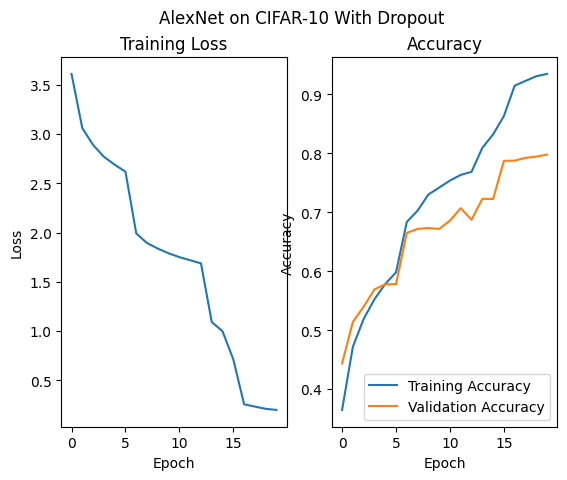

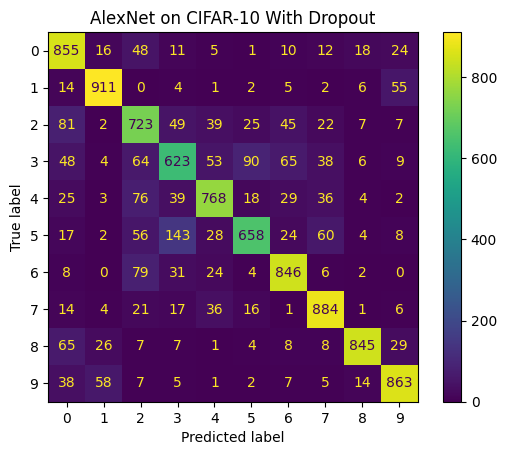

In [40]:
alex_drop.plot_training('AlexNet on CIFAR-10 With Dropout')
alex_drop.plot_confusion_matrix('AlexNet on CIFAR-10 With Dropout')

In [54]:
retrain_alex_100 = True
if retrain_alex_100:
    alex_100 = AlexNet(
        in_chan = 3,
        in_dim=(32, 32),
        num_classes=100,
        block_params = [
            ConvParams(kernel=5, out_chan=96, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=128, stride=1, padding='same'),
        ],
        cnv_params = [
            ConvParams(kernel=5, out_chan=128, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=96, stride=1, padding='same'),
            ConvParams(kernel=3, out_chan=64, stride=1, padding='same'),
        ],
        fc_layers=[2048, 4096, 1000],
        dropout = 0
    ).to(device)

    alex_100.train_model(
        epochs=20,
        train_loader=cifar100_train_loader,
        val_loader=cifar100_val_loader,
        alpha=1e-3,
        optimizer=torch.optim.Adam,
        print_epoch=1,   
    )
    torch.save(alex_100, 'models/alex_100.pth')
else:
    alex_100 = torch.load('models/alex_100.pth')
    alex_100.to(device)

torch.Size([1, 100])


NameError: name 'cifar100_train_loader' is not defined

In [ ]:
alex_100.plot_training('AlexNet on CIFAR-100')
alex_100.plot_confusion_matrix('AlexNet on CIFAR-100')

In [ ]:
def get_conv_relu(cnv_params: ConvParams):
    return nn.Sequential(
        nn.Conv2d(**cnv_params.__dict__()),
        nn.ReLU()
    )


class VggBlock(nn.Module):
    def __init__(
        self,
        params: ConvParams,
        pool_kernel = 2,
        pool_stride = 2,
        repitions = 2,
    ):
        super().__init__()
        self.computation = nn.Sequential(
            *[get_conv_relu(**params.__dict__()) for _ in range(repitions)],
            nn.MaxPool2d(pool_kernel, pool_stride),
        )
        self.pool = nn.MaxPool2d(pool_kernel, pool_stride)
    def forward(self, x):
        return self.computation(x)

class VggNet(Classifier):
    def __init__(
            self,
            in_chan,
            in_dim,
            num_classes,
            block_params: list = [],
            fc_layers = [],
        ):
        self.sequential == nn.Sequential()
        super().__init__()
        for i in range(len(block_params)):
            if i == 0:
                block_params[i][0].in_chan = in_chan
            else:
                block_params[i][0].in_chan = block_params[i-1][0].out_chan
            self.sequential.add_module(name=f'block_{i}', module=VggBlock(**block_params[i][0].__dict__(), repitions=block_params[i][1]))
        self.sequential.add_module(name='flatten', module=nn.Flatten())
        dummy_in = torch.randn(1, in_chan, *in_dim).to(device)
        dummy_out = self.sequential(dummy_in)
        fc_in = dummy_out.shape[1]
        
        for i in range(len(fc_layers)):
            layer_in = 0
            if i == 0:
                layer_in = fc_in
            else:
                layer_in = fc_layers[i-1]
            self.sequential.add_module(name=f'linear_{i}', module=nn.Sequential(
                nn.Linear(layer_in, fc_layers[i]),
                nn.ReLU(),
            ))
        self.sequential.add_module(name = 'output', module=nn.Linear(fc_layers[-1], num_classes))        
        self.sequential = self.sequential.to(device)

In [ ]:
if retrain_vgg